# Data Analysis Practice on 2021 data

## Brainstorming of Questions
1. Are there more break points in clay court matches?
2. Is there a correlation between tournament level and length of match?
3. Is there a correlation between length of match and difference between player rankings?
4. Is there a correlation between 1st serve in % and break points faced?
5. Is there a correlation between player height and no. aces?
6. Who had the best tie break record in the calendar year?
7. Is there a correlation between tie break percentage win and end of year ranking? (would need to get the end of year ranking form somewhere else I think)
8. Is there a correlation between difference in total games won and difference in first serve in percentage (per match)?


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import Union

df = pd.read_csv('data/atp_matches_2021.csv')
df = df.astype({'tourney_date':'string'})
df.tourney_date = pd.to_datetime(df.tourney_date)
pd.set_option('display.max_columns', None)
df = df.sort_values(by =['tourney_date', 'match_num'])
df = df.reset_index()
df

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1158,2021-0499,Delray Beach,Hard,32,A,2021-01-04,271,106329,NaN,NaN,Thiago Monteiro,L,183.0,BRA,26.5,105064,NaN,NaN,Thomaz Bellucci,L,188.0,BRA,33.0,6-3 7-5,3,R32,100.0,2.0,1.0,67.0,38.0,28.0,16.0,10.0,8.0,9.0,3.0,3.0,69.0,42.0,25.0,12.0,11.0,2.0,6.0,84.0,820.0,281.0,185.0
1,1159,2021-0499,Delray Beach,Hard,32,A,2021-01-04,272,200624,NaN,NaN,Sebastian Korda,R,196.0,USA,20.5,126952,NaN,NaN,Soon Woo Kwon,R,180.0,KOR,23.0,6-4 6-4,3,R32,93.0,8.0,1.0,88.0,53.0,36.0,18.0,10.0,5.0,6.0,4.0,4.0,50.0,29.0,22.0,11.0,10.0,1.0,4.0,119.0,566.0,95.0,768.0
2,1160,2021-0499,Delray Beach,Hard,32,A,2021-01-04,273,126205,5.0,NaN,Tommy Paul,R,185.0,USA,23.6,106227,NaN,NaN,Ji Sung Nam,R,183.0,KOR,27.3,6-1 6-4,3,R32,67.0,5.0,0.0,59.0,38.0,26.0,13.0,9.0,2.0,3.0,2.0,4.0,51.0,27.0,16.0,10.0,8.0,2.0,6.0,52.0,1080.0,268.0,205.0
3,1161,2021-0499,Delray Beach,Hard,32,A,2021-01-04,275,111815,NaN,NaN,Cameron Norrie,L,188.0,GBR,25.3,111574,NaN,WC,Jc Aragone,R,178.0,USA,25.5,6-2 6-1,3,R32,67.0,3.0,2.0,48.0,31.0,26.0,10.0,8.0,3.0,3.0,2.0,2.0,47.0,28.0,13.0,7.0,7.0,4.0,8.0,74.0,877.0,299.0,165.0
4,1162,2021-0499,Delray Beach,Hard,32,A,2021-01-04,276,106216,NaN,NaN,Bjorn Fratangelo,R,183.0,USA,27.4,110536,NaN,Q,Kevin King,U,190.0,USA,29.8,6-2 6-2,3,R32,69.0,0.0,0.0,51.0,25.0,22.0,15.0,8.0,2.0,2.0,2.0,2.0,49.0,32.0,17.0,7.0,8.0,2.0,6.0,274.0,195.0,304.0,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2635,2021-M-DC-2021-FLS-M-CRO-SRB-01,Davis Cup Finals SF: CRO vs SRB,Hard,2,D,2021-12-03,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.5,105227,NaN,NaN,Marin Cilic,R,198.0,CRO,33.1,6-4 6-2,3,RR,99.0,4.0,1.0,60.0,40.0,30.0,12.0,9.0,8.0,8.0,6.0,3.0,66.0,37.0,23.0,13.0,9.0,5.0,8.0,1.0,11540.0,30.0,1710.0
2729,2642,2021-M-DC-2021-FLS-M-RTF-GER-01,Davis Cup Finals SF: RTF vs GER,Hard,2,D,2021-12-04,1,126094,NaN,NaN,Andrey Rublev,R,188.0,RUS,24.1,136440,NaN,NaN,Dominik Koepfer,L,180.0,GER,27.5,6-4 6-0,3,RR,48.0,9.0,2.0,43.0,32.0,27.0,6.0,8.0,0.0,0.0,2.0,2.0,43.0,21.0,12.0,10.0,8.0,0.0,4.0,5.0,5150.0,54.0,1101.0
2730,2643,2021-M-DC-2021-FLS-M-RTF-GER-01,Davis Cup Finals SF: RTF vs GER,Hard,2,D,2021-12-04,2,106421,NaN,NaN,Daniil Medvedev,R,198.0,RUS,25.7,105526,NaN,NaN,Jan Lennard Struff,R,193.0,GER,31.5,6-4 6-4,3,RR,66.0,7.0,0.0,50.0,35.0,29.0,12.0,10.0,1.0,1.0,5.0,4.0,54.0,34.0,29.0,7.0,10.0,3.0,5.0,2.0,8640.0,51.0,1134.0
2731,2640,2021-M-DC-2021-FLS-M-RTF-CRO-01,Davis Cup Finals F: RTF vs CRO,Hard,2,D,2021-12-05,1,126094,NaN,NaN,Andrey Rublev,R,188.0,RUS,24.1,127339,NaN,NaN,Borna Gojo,R,196.0,CRO,23.7,6-4 7-6(5),3,RR,92.0,8.0,2.0,57.0,39.0,36.0,12.0,11.0,0.0,0.0,15.0,2.0,83.0,52.0,33.0,20.0,11.0,7.0,8.0,5.0,5150.0,279.0,196.0


## Dealing with the Score

### Total games won by winner and loser

The score for each set can be in one of 6 formats:
1. 6-x
2. x-6
3. 7-5
4. 5-7
5. 7-6(x)
6. (x)6-7

- From these formats, winner_games_won and loser_games_won can be calculated. Conveniently, winner's games is always quoted first (even if it goes to three sets) so once split these can just be calculated as such. 

- [Edit]: Inevitably encountered some alternative formats such as `4-6 6-3 [7-10]` which is when they had a first to 10 tie break to decide the match instead of a third set in some formats (usually doubles)

- Now I have number of games won for each player, paired with number of break points faced, number of break points saved and total number of service games, I can find how many service games they won and lost. 

In [74]:
def get_winner_games_won(score: str) -> int:
    """Takes in the score for the match and returns the number of games won by the winner

    Args:
        score (str): The score as a string 

    Returns:
        Int : The winners total games won
    """
    w_games = 0
    sets = score.split(' ')
    for set in sets:
        if 'R' in set or 'W' in set or 'Def.' in set or '[' in set:
            continue 
        if set[0] == '(':
            w_games += 6
            continue
        if set[-1] == ')':
            w_games += 7
            continue 
        games = set.split('-')
        w_games += int(games[0])
    return w_games

def get_loser_games_won(score: str) -> int:
    """Takes in the score for the match and returns the number of games won by the loser 

    Args:
        score (str): The score as a string 

    Returns:
        int: The losers total games won
    """
    l_games = 0
    sets = score.split(' ')
    for set in sets:
        if 'R' in set or 'W' in set or 'Def.' in set or '[' in set:
            continue 
        if set[0] == '(':
            l_games += 7
            continue
        if set[-1] == ')':
            l_games += 6
            continue 
        games = set.split('-')
        l_games += int(games[1])
    return l_games

In [193]:
df['w_GmsWon'] = df['score'].apply(lambda x: get_winner_games_won(x))
df['l_GmsWon'] = df['score'].apply(lambda x: get_loser_games_won(x))

/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/3639046712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w_GmsWon'] = df['score'].apply(lambda x: get_winner_games_won(x))
/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/3639046712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['l_GmsWon'] = df['score'].apply(lambda x: get_loser_games_won(x))


### Tie breaks 

Can make a tally of number of tie breaks in a match and who won. Can use this data to discover who had the best tie break record in the season etc. 

In [209]:
def tie_break_count(score: str) -> int:
    """Takes the score of the match and returns the number of tie breaks that occured

    Args:
        score (str): The matches score as a string

    Returns:
        int: Number of tie breaks in the match 
    """
    num_tb = 0
    sets = score.split(' ')
    for set in sets:
        if '(' in set:
            num_tb += 1
    return num_tb

def tie_breaks_won_by_winner(score: str) -> int:
    """Calculates the number of tie breaks won in the match by the winner

    Args:
        score (str): The score as a string

    Returns:
        int: The number of tie breaks won by the winner
    """
    w_tb = 0
    sets = score.split(' ')
    for set in sets:
        if set[-1] == ')' and set[0] == '7':
            w_tb += 1
    return w_tb

def tie_breaks_won_by_loser(score: str) -> int:
    """Calculates the number of tie breaks won in the match by the loser

    Args:
        score (str): The score as a string

    Returns:
        int: The number of tie breaks won by the loser
    """
    l_tb = 0
    sets = score.split(' ')
    for set in sets:
        if set[-1] == ')' and set[0] == '6':
            l_tb += 1
    return l_tb


In [210]:
df['tb_num'] = df['score'].apply(lambda x: tie_break_count(x))
df['w_tbWon'] = df['score'].apply(lambda x: tie_breaks_won_by_winner(x))
df['l_tbWon'] = df['score'].apply(lambda x: tie_breaks_won_by_loser(x))

/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/1387119875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tb_num'] = df['score'].apply(lambda x: tie_break_count(x))
/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/1387119875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w_tbWon'] = df['score'].apply(lambda x: tie_breaks_won_by_winner(x))
/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/1387119875.py:3: SettingWithCopyWarning: 
A value is tr

## Answering the Questions 

### Are there more break points in clay court matches?

In [99]:
df['bpTotal'] = df.w_bpFaced + df.l_bpFaced

In [122]:
matches_per_surface = df.groupby('surface')['bpTotal'].count()
bp_per_surface = df.groupby('surface')['bpTotal'].sum()
bp_per_match_per_surface = bp_per_surface / matches_per_surface
bp_per_match_per_surface.reset_index()
(bp_per_match_per_surface[0]/bp_per_match_per_surface[1] * 100) - 100 # Percentage more break points on clay than on grass

12.71904717662538

<AxesSubplot: xlabel='surface'>

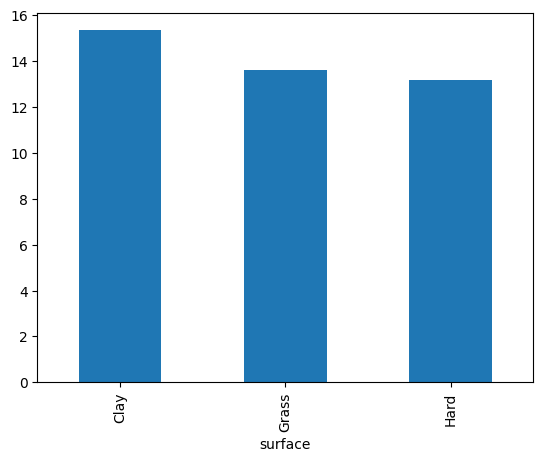

In [117]:
bp_per_match_per_surface.plot.bar('surface', 'bpTotal')

It can be seen in the previous graph that there are more break points per match on average on Clay than on any other surface. 12.7% more than on the next highest surface, Grass. 

### Is there a correlation between tournament level and length of match?

To answer this I will plot the average length of match for each tournament level, much like I did above with break points and match surface.    

In [126]:
df.groupby('tourney_level')['index'].count()

tourney_level
A    1569
D     129
F      15
G     508
M     512
Name: index, dtype: int64

In [137]:
df[df.tourney_level == 'A'] # Regular ATP tour tournaments (250 and 500 level)
df[df.tourney_level == 'D'] # Davis Cup. Difficult to quantify this so will be left out 
df[df.tourney_level == 'F'] # ATP Finals 
df[df.tourney_level == 'G'] # Grand Slams
df[df.tourney_level == 'M'] # Masters Tournaments 
df_no_D = df[df.tourney_level != 'D']

<AxesSubplot: xlabel='tourney_level'>

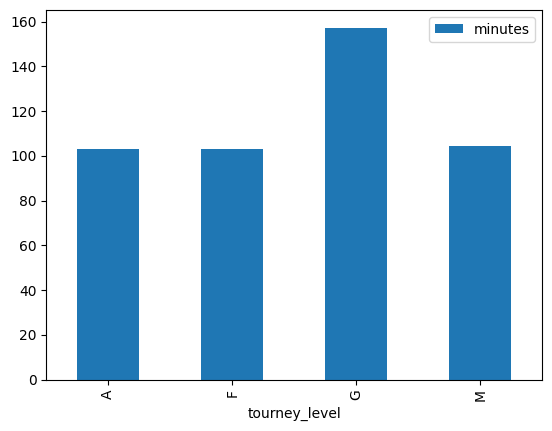

In [143]:
average_time_per_match = df_no_D.groupby('tourney_level')['minutes'].mean().reset_index()
average_time_per_match.plot.bar('tourney_level', 'minutes')

### Is there a correlation between length of match and difference between player rankings?

In [155]:
df_no_D['rank_difference'] = df_no_D['loser_rank'] - df_no_D['winner_rank']
df_no_rd_outliers = df_no_D[(df_no_D.rank_difference < 400) & (df_no_D.rank_difference > -400)]

/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/876185831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_D['rank_difference'] = df_no_D['loser_rank'] - df_no_D['winner_rank']


<AxesSubplot: xlabel='rank_difference', ylabel='minutes'>

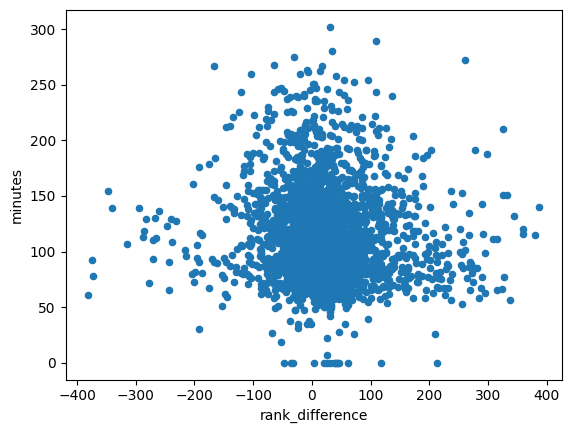

In [156]:
df_no_rd_outliers.plot.scatter('rank_difference', 'minutes')

<AxesSubplot: xlabel='rank_difference', ylabel='minutes'>

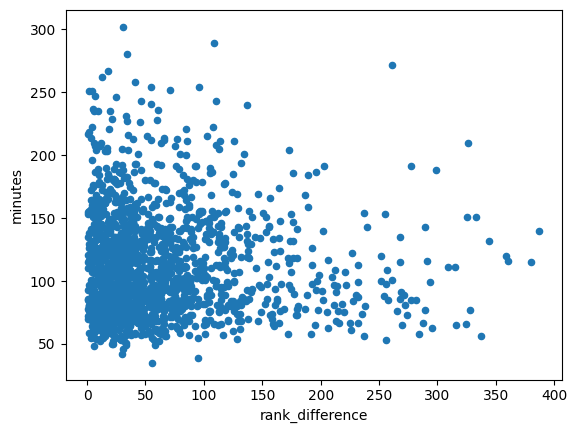

In [161]:
df_no_rd_outliers_no_neg = df_no_D[(df_no_D.rank_difference < 400) & (df_no_D.rank_difference > 0) & (df_no_D.minutes > 30)]
df_no_rd_outliers_no_neg.plot.scatter('rank_difference', 'minutes')

In [165]:
df_no_rd_outliers_no_neg['rank_difference'].corr(df_no_rd_outliers_no_neg['minutes'])

-0.03658210046490659

- After removing the outliers (matches where the ranking difference was > 400) there doesn't appear to be any correlation between rank difference and minutes played. 
- Looking at the data where the higher ranked player won (positive rank distance) there appears to be a slight negative correlation but when you check them numerically a number of -0.0366 shows that there is no essentially no correlation 

### Is there a correlation between 1st serve in % and break points faced?

In [168]:
df = df_no_D
# removing the davis cup from the regular dataframe as only looking at the atp tour + grand slams 

In [182]:
df['w_1stIn%'] = (df['w_1stIn']/df['w_svpt'])*100
df['l_1stIn%'] = (df['l_1stIn']/df['l_svpt'])*100
df['w_1stWin%'] = (df['w_1stWon']/df['w_1stIn'])*100
df['l_1stWin%'] = (df['l_1stWon']/df['l_1stIn'])*100
df = df[df['l_1stWin%'] > 0]

/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/3213723011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w_1stIn%'] = (df['w_1stIn']/df['w_svpt'])*100
/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/3213723011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['l_1stIn%'] = (df['l_1stIn']/df['l_svpt'])*100
/var/folders/yl/1t3fhfr937ddzqvs9dr51wtc0000gn/T/ipykernel_36963/3213723011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

-0.084294653222099

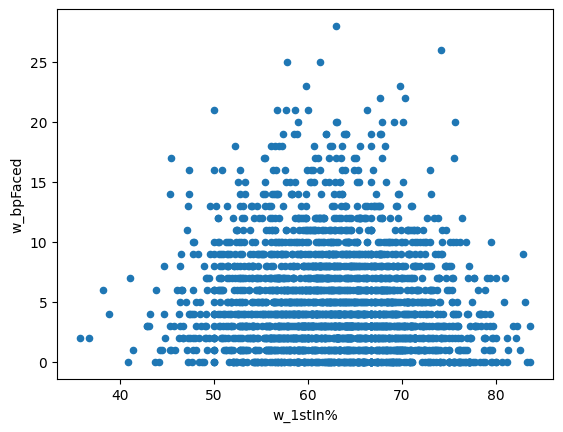

In [183]:
df.plot.scatter('w_1stIn%', 'w_bpFaced')
df['w_1stIn%'].corr(df['w_bpFaced'])
# No correlation shown between 1st serve percentage and break points faced 

-0.5766428727907389

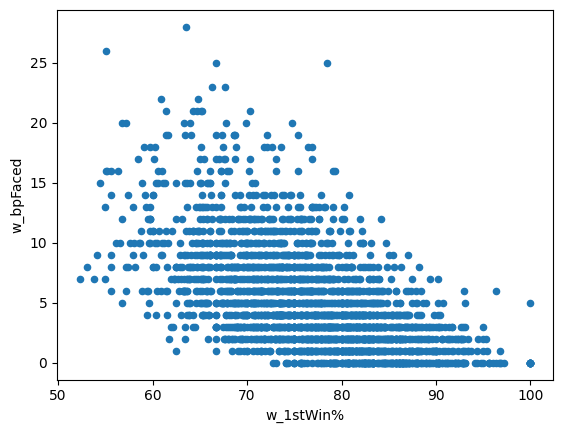

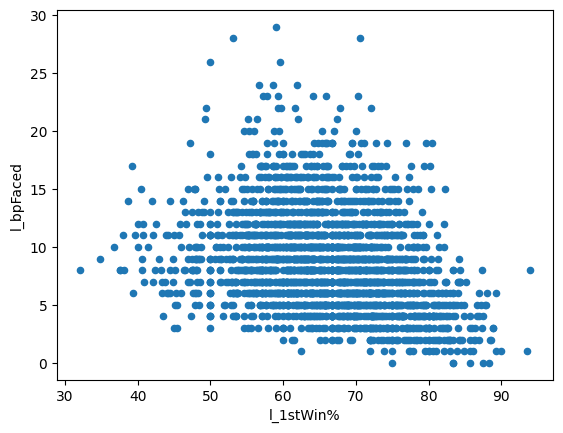

In [184]:
df.plot.scatter('w_1stWin%', 'w_bpFaced')
df.plot.scatter('l_1stWin%', 'l_bpFaced')
df['w_1stWin%'].corr(df['w_bpFaced'])
# much more of a pronounced negative correlation when looking at 1st serve win percentage. The higher the first serve win 
# percentage, the fewer break points the winner faced

### Is there a correlation between player height and no. aces?

0.49229053632578357

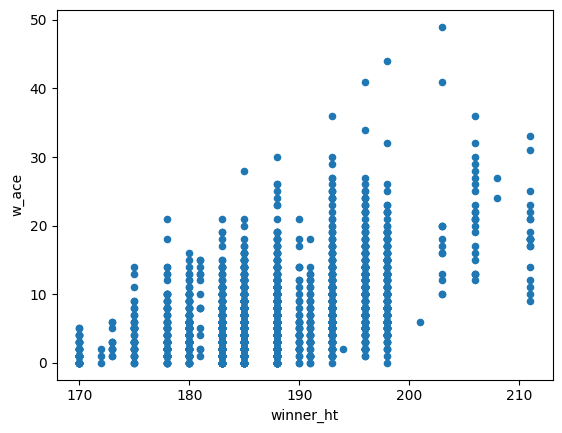

In [187]:
df.plot.scatter('winner_ht', 'w_ace')
df['winner_ht'].corr(df['w_ace'])
# quite a strong positive correlation between the height of the winner and the number of aces hit 

###  Who had the best tie break record in the calendar year?

In [220]:
w_tb_won = df.groupby('winner_name')['w_tbWon'].sum().reset_index().sort_values('w_tbWon', ascending=False)
l_tb_won = df.groupby('loser_name')['l_tbWon'].sum().reset_index().sort_values('l_tbWon', ascending=False)

w_tb_won.rename(columns={'winner_name': 'player_name'}, inplace=True)
l_tb_won.rename(columns={'loser_name': 'player_name'}, inplace=True)

In [233]:
import numpy as np
total_tb_won = l_tb_won.merge(w_tb_won, on='player_name', how='outer')
total_tb_won['tb_won'] = total_tb_won['l_tbWon'] + total_tb_won['w_tbWon']
total_tb_won.replace(np.NaN, 0)
total_tb_won.sort_values('tb_won', ascending=False).reset_index()

,index,player_name,l_tbWon,w_tbWon,tb_won
0,2,Alexei Popyrin,5.0,18.0,23.0
1,0,Reilly Opelka,5.0,17.0,22.0
2,7,Alexander Zverev,4.0,18.0,22.0
3,64,John Isner,2.0,19.0,21.0
4,16,Jannik Sinner,3.0,18.0,21.0
...,...,...,...,...,...
305,298,Hamad Medjedovic,0.0,NaN,NaN
306,303,James Ward,0.0,NaN,NaN
307,306,Jay Clarke,0.0,NaN,NaN
308,308,Nicolas Mahut,NaN,1.0,NaN


### Is there a correlation between tie break percentage win and end of year ranking? (would need to get the end of year ranking form somewhere else I think)